In [ ]:

# cell-1 :Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install -q opencv-python-headless scikit-learn matplotlib

print("✓ Dependencies installed successfully!")

Mounted at /content/drive
✓ Dependencies installed successfully!


In [ ]:
#cell-2:Import All necessary Libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
import numpy as np
import cv2
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("✓ Libraries imported successfully!")


TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✓ Libraries imported successfully!


In [ ]:
# CELL 3: Configuration

class Config:
    """Configuration parameters for the model"""
    # Image parameters
    IMG_HEIGHT = 128
    IMG_WIDTH = 128
    IMG_CHANNELS = 1  # Grayscale thermal images

    # Training parameters
    BATCH_SIZE = 16
    EPOCHS = 35
    LEARNING_RATE = 5e-4

    # Dataset paths - MODIFY THESE ACCORDING TO YOUR GOOGLE DRIVE STRUCTURE
    BASE_PATH = '/content/drive/MyDrive/'  # Change this!
    TRAIN_IMAGES_PATH = f'{BASE_PATH}/dataset/data/train/images'
    TRAIN_MASKS_PATH = f'{BASE_PATH}/dataset/data/train/masks'
    VAL_IMAGES_PATH = f'{BASE_PATH}/dataset/data/val/images'
    VAL_MASKS_PATH = f'{BASE_PATH}/dataset/data/val/masks'
    TEST_IMAGES_PATH = f'{BASE_PATH}/dataset/data/test/images'
    TEST_MASKS_PATH = f'{BASE_PATH}/dataset/data/test/masks'

    # Model save path
    MODEL_SAVE_PATH = f'{BASE_PATH}/myDrive/u-net(2) output'
    CHECKPOINT_PATH = f'{BASE_PATH}/mydrive/u-net(2) output'

config = Config()
print("✓ Configuration loaded!")
print(f"Base Path: {config.BASE_PATH}")


✓ Configuration loaded!
Base Path: /content/drive/MyDrive/


In [ ]:
  # CELL 4: Data Loading Functions
from glob import glob
def load_dataset_paths(images_dir, masks_dir):
    """Load paths to images and corresponding masks"""
    image_paths = sorted(glob(os.path.join(images_dir, '*.*')))
    mask_paths = sorted(glob(os.path.join(masks_dir, '*.*')))

    # Filter valid image extensions
    valid_ext = ('.png', '.jpg', '.jpeg', '.bmp', '.tif')
    image_paths = [p for p in image_paths if p.lower().endswith(valid_ext)]
    mask_paths = [p for p in mask_paths if p.lower().endswith(valid_ext)]

    print(f"Found {len(image_paths)} images and {len(mask_paths)} masks")

    if len(image_paths) != len(mask_paths):
        print("⚠ Warning: Mismatch between images and masks!")

    return image_paths, mask_paths

# Test data loading
print("\nChecking dataset directories...")
try:
    train_images, train_masks = load_dataset_paths(config.TRAIN_IMAGES_PATH, config.TRAIN_MASKS_PATH)
    val_images, val_masks = load_dataset_paths(config.VAL_IMAGES_PATH, config.VAL_MASKS_PATH)
    test_images, test_masks = load_dataset_paths(config.TEST_IMAGES_PATH, config.TEST_MASKS_PATH)

    print(f"\n✓ Dataset Summary:")
    print(f"  Training: {len(train_images)} samples")
    print(f"  Validation: {len(val_images)} samples")
    print(f"  Test: {len(test_images)} samples")
except Exception as e:
    print(f"✗ Error loading dataset: {e}")
    print("Please check your dataset paths in the Config class!")




Checking dataset directories...
Found 1050 images and 1061 masks
⚠ Warning: Mismatch between images and masks!
Found 225 images and 225 masks
Found 225 images and 225 masks

✓ Dataset Summary:
  Training: 1050 samples
  Validation: 225 samples
  Test: 225 samples


In [ ]:
# CELL 5: Data Generator Class

class DataGenerator(keras.utils.Sequence):
    """Custom data generator for loading and augmenting thermal images"""

    def __init__(self, image_paths, mask_paths, batch_size=8,
                 img_size=(128, 128), augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.indexes = np.arange(len(self.image_paths))

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.image_paths[i] for i in batch_indexes]
        batch_masks = [self.mask_paths[i] for i in batch_indexes]

        X, y = self._load_batch(batch_images, batch_masks)
        return X, y

    def on_epoch_end(self):
        """Shuffle data after each epoch"""
        np.random.shuffle(self.indexes)

    def _load_batch(self, image_paths, mask_paths):
        """Load and preprocess a batch of images and masks"""
        X = np.zeros((len(image_paths), *self.img_size, 1), dtype=np.float32)
        y = np.zeros((len(mask_paths), *self.img_size, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
            # Load image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Could not load {img_path}")
                continue
            img = cv2.resize(img, self.img_size)

            # Load mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Warning: Could not load {mask_path}")
                continue
            mask = cv2.resize(mask, self.img_size)

            # Apply augmentation if enabled
            if self.augment:
                img, mask = self._augment(img, mask)

            # Normalize to [0, 1]
            img = img.astype(np.float32) / 255.0
            mask = mask.astype(np.float32) / 255.0

            X[i] = np.expand_dims(img, axis=-1)
            y[i] = np.expand_dims(mask, axis=-1)

        return X, y

    def _augment(self, img, mask):
        """Apply data augmentation techniques"""
        # Random rotation
        if np.random.rand() > 0.5:
            angle = np.random.randint(-15, 15)
            M = cv2.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), angle, 1.0)
            img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
            mask = cv2.warpAffine(mask, M, (mask.shape[1], mask.shape[0]))

        # Random horizontal flip
        if np.random.rand() > 0.5:
            img = cv2.flip(img, 1)
            mask = cv2.flip(mask, 1)

        # Random vertical flip
        if np.random.rand() > 0.5:
            img = cv2.flip(img, 0)
            mask = cv2.flip(mask, 0)

        # Random brightness adjustment
        if np.random.rand() > 0.5:
            brightness = np.random.uniform(0.8, 1.2)
            img = np.clip(img * brightness, 0, 255).astype(np.uint8)

        return img, mask

print("✓ DataGenerator class defined!")

# class ImprovedDataGenerator(keras.utils.Sequence):
#     """Enhanced data generator with better preprocessing"""

#     def __init__(self, image_paths, mask_paths, batch_size=8,
#                  img_size=(128, 128), augment=False, use_clahe=True):
#         self.image_paths = image_paths
#         self.mask_paths = mask_paths
#         self.batch_size = batch_size
#         self.img_size = img_size
#         self.augment = augment
#         self.use_clahe = use_clahe
#         self.indexes = np.arange(len(self.image_paths))

#         # CLAHE for better contrast
#         self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

#     def __len__(self):
#         return int(np.ceil(len(self.image_paths) / self.batch_size))

#     def __getitem__(self, index):
#         batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
#         batch_images = [self.image_paths[i] for i in batch_indexes]
#         batch_masks = [self.mask_paths[i] for i in batch_indexes]

#         X, y = self._load_batch(batch_images, batch_masks)
#         return X, y

#     def on_epoch_end(self):
#         np.random.shuffle(self.indexes)

#     def _preprocess_thermal_image(self, img):
#         """Enhanced preprocessing for thermal images"""
#         # Apply CLAHE for better contrast
#         if self.use_clahe:
#             img = self.clahe.apply(img)

#         # Denoise using bilateral filter
#         img = cv2.bilateralFilter(img, 9, 75, 75)

#         # Enhance edges
#         img = cv2.addWeighted(img, 1.5, cv2.GaussianBlur(img, (0, 0), 3), -0.5, 0)

#         return img

#     def _load_batch(self, image_paths, mask_paths):
#         X = np.zeros((len(image_paths), *self.img_size, 1), dtype=np.float32)
#         y = np.zeros((len(mask_paths), *self.img_size, 1), dtype=np.float32)

#         for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
#             # Load image
#             img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#             if img is None:
#                 continue

#             # Apply enhanced preprocessing
#             img = self._preprocess_thermal_image(img)
#             img = cv2.resize(img, self.img_size, interpolation=cv2.INTER_CUBIC)

#             # Load mask
#             mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#             if mask is None:
#                 continue
#             mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)

#             # Binarize mask (important!)
#             _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

#             # Apply augmentation
#             if self.augment:
#                 img, mask = self._augment(img, mask)

#             # Normalize
#             img = img.astype(np.float32) / 255.0
#             mask = mask.astype(np.float32) / 255.0

#             X[i] = np.expand_dims(img, axis=-1)
#             y[i] = np.expand_dims(mask, axis=-1)

#         return X, y

#     def _augment(self, img, mask):
#         """Enhanced augmentation strategy"""
#         # Random rotation (-20 to 20 degrees)
#         if np.random.rand() > 0.3:
#             angle = np.random.randint(-20, 20)
#             M = cv2.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), angle, 1.0)
#             img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
#             mask = cv2.warpAffine(mask, M, (mask.shape[1], mask.shape[0]))

#         # Random flip
#         if np.random.rand() > 0.5:
#             img = cv2.flip(img, 1)
#             mask = cv2.flip(mask, 1)

#         if np.random.rand() > 0.5:
#             img = cv2.flip(img, 0)
#             mask = cv2.flip(mask, 0)

#         # Random brightness/contrast
#         if np.random.rand() > 0.5:
#             alpha = np.random.uniform(0.7, 1.3)  # Contrast
#             beta = np.random.randint(-30, 30)     # Brightness
#             img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

#         # Random Gaussian noise
#         if np.random.rand() > 0.7:
#             noise = np.random.normal(0, 5, img.shape).astype(np.uint8)
#             img = cv2.add(img, noise)

#         # Random elastic deformation (advanced)
#         if np.random.rand() > 0.8:
#             img, mask = self._elastic_transform(img, mask)

#         return img, mask

#     def _elastic_transform(self, img, mask, alpha=30, sigma=5):
#         """Elastic deformation augmentation"""
#         shape = img.shape
#         dx = cv2.GaussianBlur((np.random.rand(*shape) * 2 - 1), (0, 0), sigma) * alpha
#         dy = cv2.GaussianBlur((np.random.rand(*shape) * 2 - 1), (0, 0), sigma) * alpha

#         x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
#         indices = (y + dy).astype(np.float32), (x + dx).astype(np.float32)

#         img = cv2.remap(img, indices[1], indices[0], cv2.INTER_LINEAR)
#         mask = cv2.remap(mask, indices[1], indices[0], cv2.INTER_NEAREST)

#         return img, mask




✓ DataGenerator class defined!


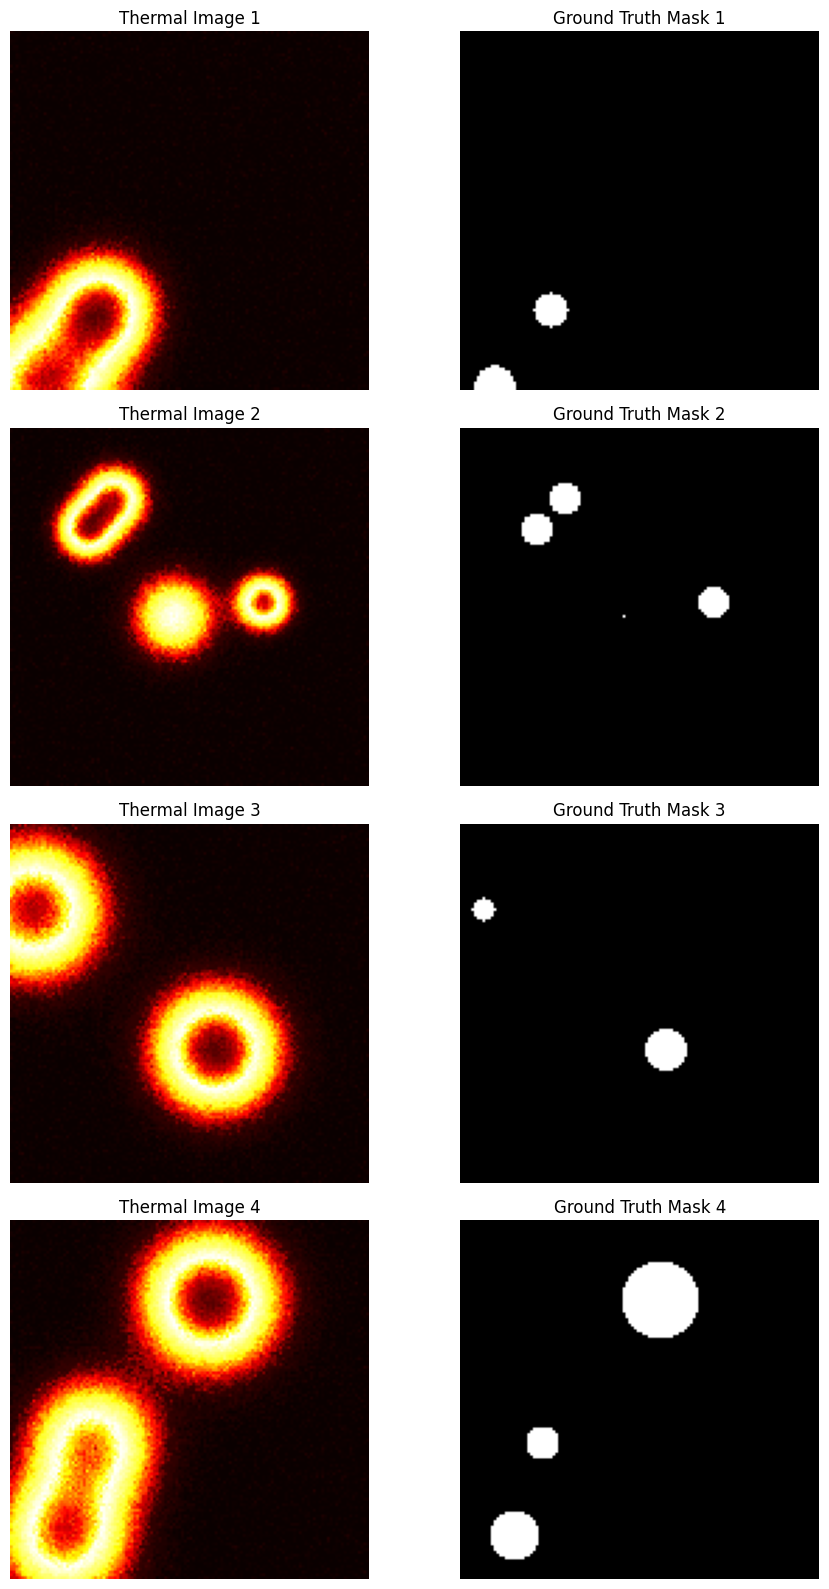

✓ Sample data visualized!


In [ ]:
# CELL 6: Visualize Sample Data

# Create data generators (without augmentation for visualization)
sample_train_gen = DataGenerator(train_images, train_masks,
                                batch_size=4,
                                img_size=(config.IMG_HEIGHT, config.IMG_WIDTH),
                                augment=False)

# Get a batch
X_sample, y_sample = sample_train_gen[0]

# Visualize
fig, axes = plt.subplots(4, 2, figsize=(10, 16))
for i in range(4):
    axes[i, 0].imshow(X_sample[i, :, :, 0], cmap='hot')
    axes[i, 0].set_title(f'Thermal Image {i+1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(y_sample[i, :, :, 0], cmap='gray')
    axes[i, 1].set_title(f'Ground Truth Mask {i+1}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.savefig(f'{config.BASE_PATH}/sample_data.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Sample data visualized!")


In [ ]:
# CELL 7: U-Net Architecture - Building Blocks

def conv_block(inputs, num_filters):
    """Convolutional block: 2x(Conv2D + BatchNorm + ReLU)"""
    x = layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

def encoder_block(inputs, num_filters):
    """Encoder block: Conv Block + Max Pooling"""
    x = conv_block(inputs, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    """Decoder block: Upsampling + Concatenation + Conv Block"""
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

print("✓ U-Net building blocks defined!")





✓ U-Net building blocks defined!


In [ ]:
# CELL 8: Build Complete U-Net Model

def build_unet(input_shape=(128, 128, 1)):
    """
    Build U-Net architecture for semantic segmentation

    Architecture:
    - Encoder: 4 blocks with [64, 128, 256, 512] filters
    - Bottleneck: 1024 filters
    - Decoder: 4 blocks with [512, 256, 128, 64] filters
    - Output: Single channel with sigmoid activation
    """
    inputs = layers.Input(input_shape)

    # Encoder path
    s1, p1 = encoder_block(inputs, 64)      # 128x128 -> 64x64
    s2, p2 = encoder_block(p1, 128)         # 64x64 -> 32x32
    s3, p3 = encoder_block(p2, 256)         # 32x32 -> 16x16
    s4, p4 = encoder_block(p3, 512)         # 16x16 -> 8x8

    # Bottleneck
    b1 = conv_block(p4, 1024)               # 8x8

    # Decoder path
    d1 = decoder_block(b1, s4, 512)         # 8x8 -> 16x16
    d2 = decoder_block(d1, s3, 256)         # 16x16 -> 32x32
    d3 = decoder_block(d2, s2, 128)         # 32x32 -> 64x64
    d4 = decoder_block(d3, s1, 64)          # 64x64 -> 128x128

    # Output layer
    outputs = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(d4)

    model = models.Model(inputs, outputs, name='U-Net-Thermal-Runaway')
    return model

# Build the model
model = build_unet(input_shape=(config.IMG_HEIGHT, config.IMG_WIDTH, config.IMG_CHANNELS))

print("✓ U-Net model built!")
print(f"\nModel Summary:")
model.summary()

# Count parameters
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"\n✓ Total trainable parameters: {trainable_params:,}")



✓ U-Net model built!

Model Summary:


Model: "U-Net-Thermal-Runaway"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)


✓ Total trainable parameters: 31,042,369


In [ ]:
# CELL 9: Loss Functions and Metrics
# ============================================================================

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Dice coefficient for evaluation"""
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """Dice loss for training"""
    return 1 - dice_coefficient(y_true, y_pred)

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    """Focal loss to handle class imbalance"""
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    cross_entropy = -y_true * tf.math.log(y_pred)
    weight = alpha * y_true * tf.pow((1 - y_pred), gamma)
    focal = weight * cross_entropy
    return tf.reduce_mean(focal)

def combined_loss(y_true, y_pred):
    """Combined Focal-Dice loss as specified in the paper"""
    return focal_loss(y_true, y_pred) + dice_loss(y_true, y_pred)

def iou_score(y_true, y_pred, smooth=1e-6):
    """Intersection over Union (IoU) metric"""
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

print("✓ Loss functions and metrics defined!")
print("  - Combined Focal-Dice Loss")
print("  - Dice Coefficient")
print("  - IoU Score")



✓ Loss functions and metrics defined!
  - Combined Focal-Dice Loss
  - Dice Coefficient
  - IoU Score


In [ ]:
# CELL 10: Compile Model
# ============================================================================

# Compile model with combined loss and metrics
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=config.LEARNING_RATE),
    loss=combined_loss,
    metrics=[dice_coefficient, iou_score, 'accuracy']
)

print("✓ Model compiled successfully!")
print(f"  Optimizer: Adam (lr={config.LEARNING_RATE})")
print(f"  Loss: Combined Focal-Dice Loss")
print(f"  Metrics: Dice Coefficient, IoU Score, Accuracy")



✓ Model compiled successfully!
  Optimizer: Adam (lr=0.0005)
  Loss: Combined Focal-Dice Loss
  Metrics: Dice Coefficient, IoU Score, Accuracy


In [ ]:
# CELL 11: Create Data Generators for Training
# ============================================================================

# Create data generators
train_generator = DataGenerator(
    train_images,
    train_masks,
    batch_size=config.BATCH_SIZE,
    img_size=(config.IMG_HEIGHT, config.IMG_WIDTH),
    augment=True  # Enable augmentation for training
)

val_generator = DataGenerator(
    val_images,
    val_masks,
    batch_size=config.BATCH_SIZE,
    img_size=(config.IMG_HEIGHT, config.IMG_WIDTH),
    augment=False  # No augmentation for validation
)

test_generator = DataGenerator(
    test_images,
    test_masks,
    batch_size=config.BATCH_SIZE,
    img_size=(config.IMG_HEIGHT, config.IMG_WIDTH),
    augment=False  # No augmentation for testing
)

print("✓ Data generators created!")
print(f"  Train batches: {len(train_generator)}")
print(f"  Validation batches: {len(val_generator)}")
print(f"  Test batches: {len(test_generator)}")


✓ Data generators created!
  Train batches: 66
  Validation batches: 15
  Test batches: 15


In [ ]:
# CELL 12: Setup Training Callbacks
# ============================================================================

# Create directories for saving models
os.makedirs(os.path.dirname(config.MODEL_SAVE_PATH), exist_ok=True)
os.makedirs(os.path.dirname(config.CHECKPOINT_PATH), exist_ok=True)

# FIX: Ensure paths end with .keras extension as required by Keras for saving entire models
# Temporarily update config paths for this cell's execution.
# For a permanent fix, update the Config class in CELL 3 (cell_id: 49wxO8MGWMdl).
if not config.CHECKPOINT_PATH.endswith('.keras'):
    original_checkpoint_path = config.CHECKPOINT_PATH
    config.CHECKPOINT_PATH = f'{config.CHECKPOINT_PATH}.keras'
    print(f"Adjusted CHECKPOINT_PATH for ModelCheckpoint: {original_checkpoint_path} -> {config.CHECKPOINT_PATH}")

if not config.MODEL_SAVE_PATH.endswith('.keras'):
    original_model_save_path = config.MODEL_SAVE_PATH
    config.MODEL_SAVE_PATH = f'{config.MODEL_SAVE_PATH}.keras'
    print(f"Adjusted MODEL_SAVE_PATH: {original_model_save_path} -> {config.MODEL_SAVE_PATH}")


# Define callbacks
callback_list = [
    callbacks.ModelCheckpoint(
        config.CHECKPOINT_PATH,
        monitor='val_dice_coefficient',
        mode='max',
        save_best_only=True,
        verbose=1,
        save_weights_only=False
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),
    callbacks.CSVLogger(f'{config.BASE_PATH}/training_log.csv'),
    callbacks.TensorBoard(log_dir=f'{config.BASE_PATH}/logs')
]

print("✓ Callbacks configured!")
print("  - ModelCheckpoint (saves best model)")
print("  - ReduceLROnPlateau (adaptive learning rate)")
print("  - EarlyStopping (prevents overfitting)")
print("  - CSVLogger (saves training history)")
print("  - TensorBoard (visualization)")

Adjusted CHECKPOINT_PATH for ModelCheckpoint: /content/drive/MyDrive//mydrive/u-net(2) output -> /content/drive/MyDrive//mydrive/u-net(2) output.keras
Adjusted MODEL_SAVE_PATH: /content/drive/MyDrive//myDrive/u-net(2) output -> /content/drive/MyDrive//myDrive/u-net(2) output.keras
✓ Callbacks configured!
  - ModelCheckpoint (saves best model)
  - ReduceLROnPlateau (adaptive learning rate)
  - EarlyStopping (prevents overfitting)
  - CSVLogger (saves training history)
  - TensorBoard (visualization)


In [ ]:
# CELL 13: Train the Model
# ============================================================================

print("="*70)
print("STARTING TRAINING")
print("="*70)
print(f"Epochs: {config.EPOCHS}")
print(f"Batch Size: {config.BATCH_SIZE}")
print(f"Learning Rate: {config.LEARNING_RATE}")
print("="*70)

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=config.EPOCHS,
    callbacks=callback_list,
    verbose=1
)

# Save final model
model.save(config.MODEL_SAVE_PATH)
print(f"\n✓ Training complete!")
print(f"✓ Final model saved to: {config.MODEL_SAVE_PATH}")
print(f"✓ Best model checkpoint: {config.CHECKPOINT_PATH}")



STARTING TRAINING
Epochs: 35
Batch Size: 16
Learning Rate: 0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8989 - dice_coefficient: 0.2862 - iou_score: 0.1742 - loss: 0.7172
Epoch 1: val_dice_coefficient improved from -inf to 0.08471, saving model to /content/drive/MyDrive//mydrive/u-net(2) output.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 817s 12s/step - accuracy: 0.8995 - dice_coefficient: 0.2879 - iou_score: 0.1754 - loss: 0.7155 - val_accuracy: 0.9599 - val_dice_coefficient: 0.0847 - val_iou_score: 0.0443 - val_loss: 0.9240 - learning_rate: 5.0000e-04
Epoch 2/35
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9737 - dice_coefficient: 0.5685 - iou_score: 0.4002 - loss: 0.4369
Epoch 2: val_dice_coefficient improved from 0.08471 to 0.16320, saving model to /content/drive/MyDrive//mydrive/u-net(2) output.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 316ms/step - accuracy: 0.9737 - dice_coefficient: 0.5689 - iou_score: 0.4006 - loss: 0.4365 - val_accuracy: 0.9639 - val_dice_coefficient: 0.1632 - val_iou_score: 0.0895 - val_loss: 0.8477 - lea

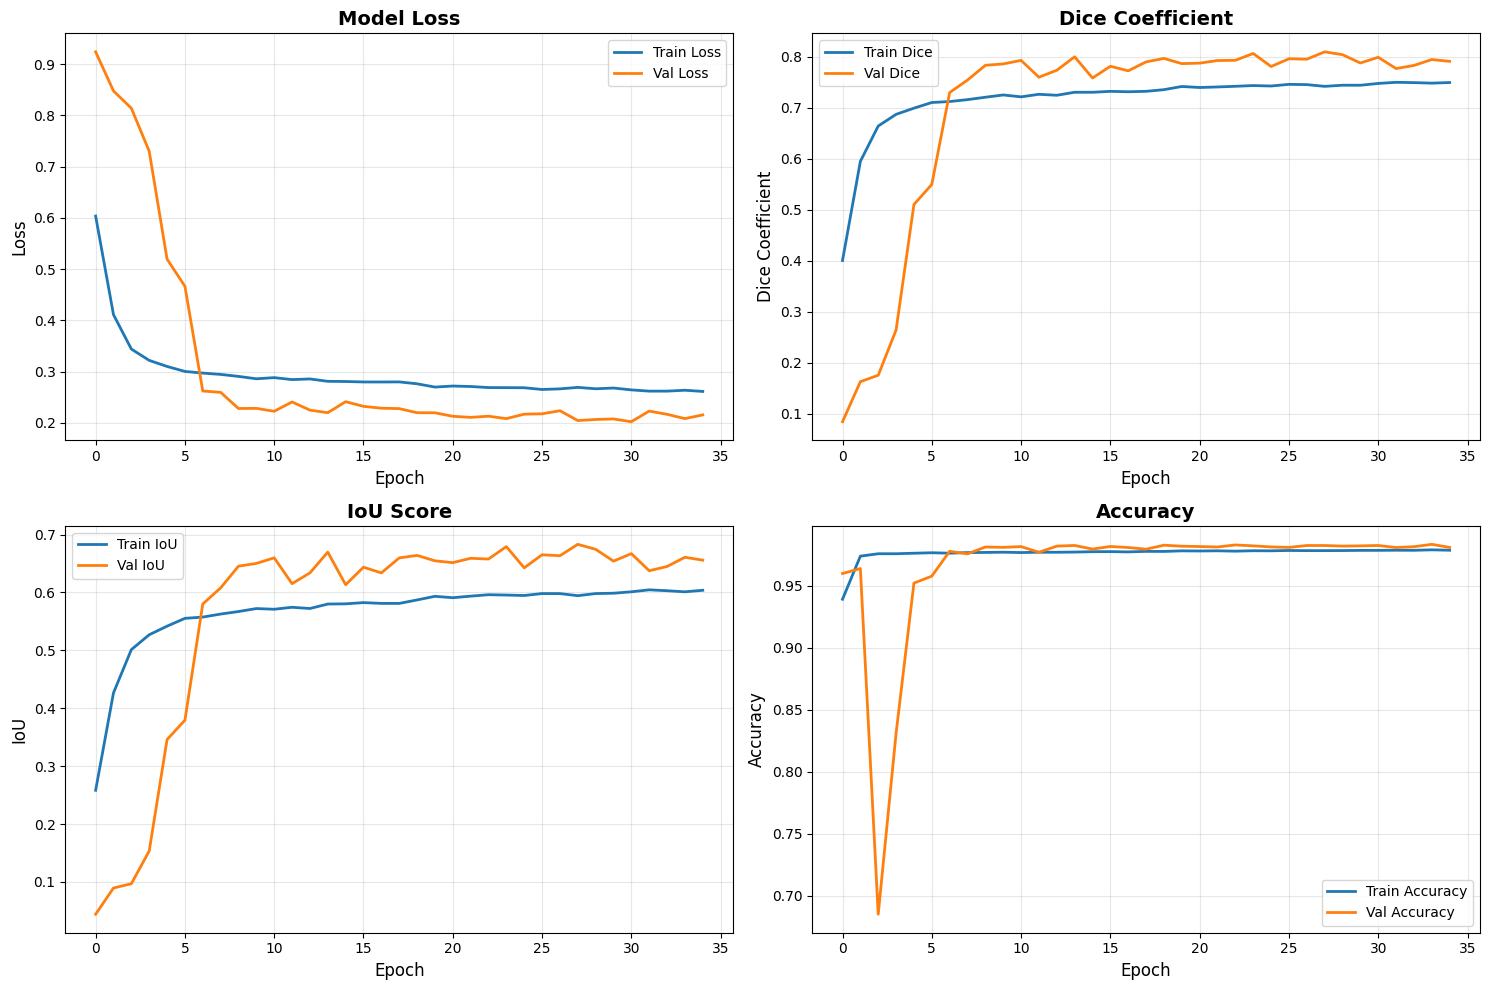

✓ Training history plotted and saved!


In [ ]:
# CELL 14: Plot Training History
# ============================================================================

def plot_training_history(history):
    """Plot training metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)

    # Dice Coefficient
    axes[0, 1].plot(history.history['dice_coefficient'], label='Train Dice', linewidth=2)
    axes[0, 1].plot(history.history['val_dice_coefficient'], label='Val Dice', linewidth=2)
    axes[0, 1].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Dice Coefficient', fontsize=12)
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)

    # IoU Score
    axes[1, 0].plot(history.history['iou_score'], label='Train IoU', linewidth=2)
    axes[1, 0].plot(history.history['val_iou_score'], label='Val IoU', linewidth=2)
    axes[1, 0].set_title('IoU Score', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('IoU', fontsize=12)
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)

    # Accuracy
    axes[1, 1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[1, 1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[1, 1].set_title('Accuracy', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Accuracy', fontsize=12)
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{config.BASE_PATH}/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot the training history
plot_training_history(history)
print("✓ Training history plotted and saved!")


In [ ]:
# CELL 15: Evaluate on Test Set
# ============================================================================

print("="*70)
print("EVALUATING ON TEST SET")
print("="*70)

# Load best model
best_model = keras.models.load_model(
    config.CHECKPOINT_PATH,
    custom_objects={
        'combined_loss': combined_loss,
        'dice_coefficient': dice_coefficient,
        'iou_score': iou_score
    }
)

# Evaluate
test_results = best_model.evaluate(test_generator, verbose=1)
test_metrics = dict(zip(best_model.metrics_names, test_results))

print("\n" + "="*70)
print("TEST SET EVALUATION RESULTS")
print("="*70)
for metric_name, value in test_metrics.items():
    print(f"{metric_name:25s}: {value:.4f}")
print("="*70)



EVALUATING ON TEST SET
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - accuracy: 0.9850 - dice_coefficient: 0.8097 - iou_score: 0.6812 - loss: 0.1950

TEST SET EVALUATION RESULTS
loss                     : 0.1926
compile_metrics          : 0.8114


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


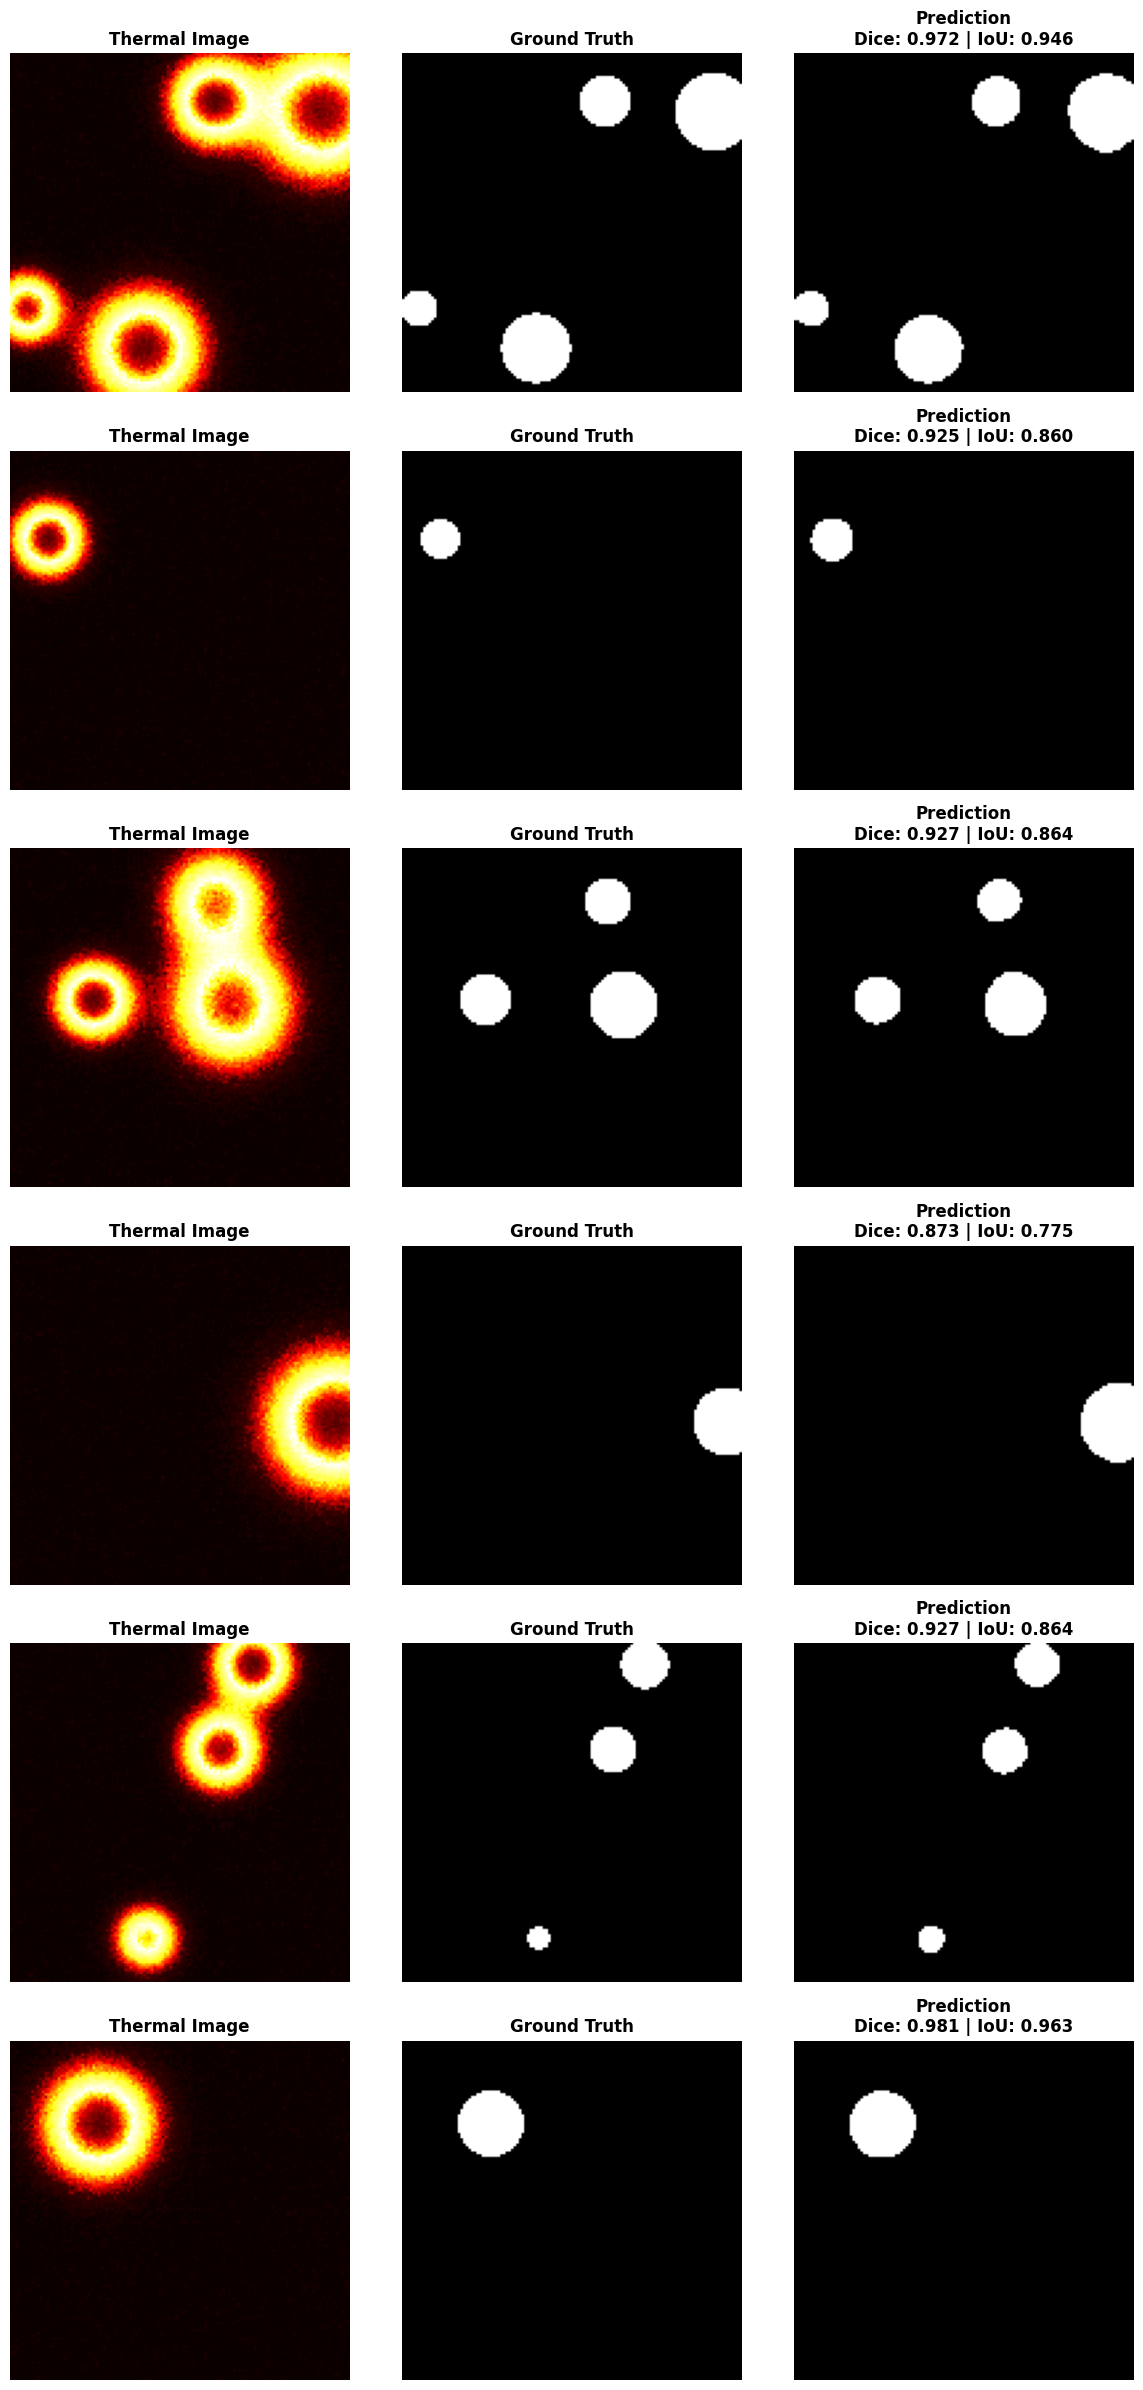

✓ Test predictions visualized and saved!


In [ ]:
# CELL 16: Visualize Predictions on Test Set
# ============================================================================

def visualize_predictions(model, test_generator, num_samples=6):
    """Visualize model predictions on test samples"""
    # Get random samples
    X_batch, y_batch = test_generator[0]
    predictions = model.predict(X_batch[:num_samples])

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        # Original thermal image
        axes[i, 0].imshow(X_batch[i, :, :, 0], cmap='hot')
        axes[i, 0].set_title('Thermal Image', fontsize=12, fontweight='bold')
        axes[i, 0].axis('off')

        # Ground truth mask
        axes[i, 1].imshow(y_batch[i, :, :, 0], cmap='gray')
        axes[i, 1].set_title('Ground Truth', fontsize=12, fontweight='bold')
        axes[i, 1].axis('off')

        # Predicted mask
        pred_mask = (predictions[i, :, :, 0] > 0.5).astype(np.float32)
        axes[i, 2].imshow(pred_mask, cmap='gray')

        # Calculate metrics for this sample
        dice = dice_coefficient(y_batch[i:i+1], predictions[i:i+1]).numpy()
        iou = iou_score(y_batch[i:i+1], predictions[i:i+1]).numpy()

        axes[i, 2].set_title(f'Prediction\nDice: {dice:.3f} | IoU: {iou:.3f}',
                            fontsize=12, fontweight='bold')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig(f'{config.BASE_PATH}/test_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize predictions
visualize_predictions(best_model, test_generator, num_samples=6)
print("✓ Test predictions visualized and saved!")



Generating predictions on entire test set...

DETAILED PERFORMANCE STATISTICS
Total test samples: 225

Dice Coefficient:
  Mean: 0.7844
  Std:  0.1867
  Min:  0.0072
  Max:  0.9811

IoU Score:
  Mean: 0.6774
  Std:  0.2134
  Min:  0.0036
  Max:  0.9629


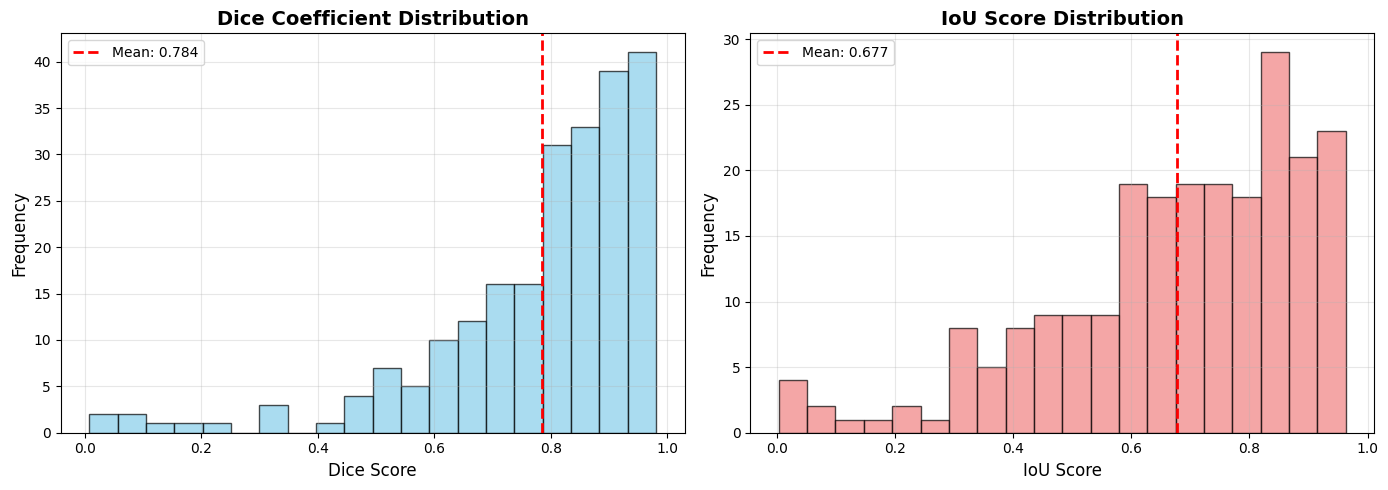

In [ ]:
# CELL 17: Detailed Performance Analysis
# ============================================================================

# Get all predictions on test set
print("Generating predictions on entire test set...")
all_predictions = []
all_ground_truths = []
all_images = []

for i in range(len(test_generator)):
    X_batch, y_batch = test_generator[i]
    pred_batch = best_model.predict(X_batch, verbose=0)

    all_images.append(X_batch)
    all_ground_truths.append(y_batch)
    all_predictions.append(pred_batch)

all_images = np.concatenate(all_images, axis=0)
all_ground_truths = np.concatenate(all_ground_truths, axis=0)
all_predictions = np.concatenate(all_predictions, axis=0)

# Calculate metrics for each sample
dice_scores = []
iou_scores = []

for i in range(len(all_predictions)):
    dice = dice_coefficient(
        all_ground_truths[i:i+1],
        all_predictions[i:i+1]
    ).numpy()

    iou = iou_score(
        all_ground_truths[i:i+1],
        all_predictions[i:i+1]
    ).numpy()

    dice_scores.append(dice)
    iou_scores.append(iou)

# Print statistics
print("\n" + "="*70)
print("DETAILED PERFORMANCE STATISTICS")
print("="*70)
print(f"Total test samples: {len(all_predictions)}")
print(f"\nDice Coefficient:")
print(f"  Mean: {np.mean(dice_scores):.4f}")
print(f"  Std:  {np.std(dice_scores):.4f}")
print(f"  Min:  {np.min(dice_scores):.4f}")
print(f"  Max:  {np.max(dice_scores):.4f}")
print(f"\nIoU Score:")
print(f"  Mean: {np.mean(iou_scores):.4f}")
print(f"  Std:  {np.std(iou_scores):.4f}")
print(f"  Min:  {np.min(iou_scores):.4f}")
print(f"  Max:  {np.max(iou_scores):.4f}")
print("="*70)

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(dice_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(dice_scores), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(dice_scores):.3f}')
axes[0].set_title('Dice Coefficient Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Dice Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(iou_scores, bins=20, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(iou_scores), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(iou_scores):.3f}')
axes[1].set_title('IoU Score Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('IoU Score', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{config.BASE_PATH}/performance_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# CELL 18: Save Performance Report
# ============================================================================

# Create comprehensive report
report = f"""
{'='*70}
U-NET THERMAL RUNAWAY DETECTION - PERFORMANCE REPORT
{'='*70}

Project: Thermal Management of EV Battery Pack Using U-Net CNN
{'='*70}
MODEL CONFIGURATION
{'='*70}
Architecture: U-Net with Skip Connections
Input Size: {config.IMG_HEIGHT}x{config.IMG_WIDTH}x{config.IMG_CHANNELS}
Trainable Parameters: {trainable_params:,}
Loss Function: Combined Focal-Dice Loss
Optimizer: Adam (lr={config.LEARNING_RATE})
Batch Size: {config.BATCH_SIZE}
Epochs Trained: {len(history.history['loss'])}

{'='*70}
DATASET SUMMARY
{'='*70}
Training Samples: {len(train_images)}
Validation Samples: {len(val_images)}
Test Samples: {len(test_images)}

{'='*70}
TEST SET PERFORMANCE
{'='*70}
"""

for metric_name, value in test_metrics.items():
    report += f"{metric_name:25s}: {value:.4f}\n"

report += f"""
{'='*70}
DETAILED STATISTICS (Test Set)
{'='*70}
Dice Coefficient:
  Mean ± Std: {np.mean(dice_scores):.4f} ± {np.std(dice_scores):.4f}
  Range: [{np.min(dice_scores):.4f}, {np.max(dice_scores):.4f}]

IoU Score:
  Mean ± Std: {np.mean(iou_scores):.4f} ± {np.std(iou_scores):.4f}
  Range: [{np.min(iou_scores):.4f}, {np.max(iou_scores):.4f}]

{'='*70}
TARGET PERFORMANCE (From Paper)
{'='*70}
Target Accuracy: >95%
Target Dice Coefficient: >0.94
Target IoU: >0.91
Target Latency: <100ms

Status: {'✓ ACHIEVED' if np.mean(dice_scores) > 0.94 else '⚠ NEEDS IMPROVEMENT'}

{'='*70}
FILES GENERATED
{'='*70}
- Model: {config.MODEL_SAVE_PATH}
- Best Checkpoint: {config.CHECKPOINT_PATH}
- Training History: {config.BASE_PATH}/training_history.png
- Test Predictions: {config.BASE_PATH}/test_predictions.png
- Performance Distribution: {config.BASE_PATH}/performance_distribution.png
- Training Log: {config.BASE_PATH}/training_log.csv
- This Report: {config.BASE_PATH}/performance_report.txt

{'='*70}
Generated: {tf.timestamp().numpy()}
{'='*70}
"""

# Save report
report_path = f'{config.BASE_PATH}/performance_report.txt'
with open(report_path, 'w') as f:
    f.write(report)

print(report)
print(f"\n✓ Performance report saved to: {report_path}")



U-NET THERMAL RUNAWAY DETECTION - PERFORMANCE REPORT

Project: Thermal Management of EV Battery Pack Using U-Net CNN
MODEL CONFIGURATION
Architecture: U-Net with Skip Connections
Input Size: 128x128x1
Trainable Parameters: 31,042,369
Loss Function: Combined Focal-Dice Loss
Optimizer: Adam (lr=0.0005)
Batch Size: 16
Epochs Trained: 35

DATASET SUMMARY
Training Samples: 1050
Validation Samples: 225
Test Samples: 225

TEST SET PERFORMANCE
loss                     : 0.1926
compile_metrics          : 0.8114

DETAILED STATISTICS (Test Set)
Dice Coefficient:
  Mean ± Std: 0.7844 ± 0.1867
  Range: [0.0072, 0.9811]

IoU Score:
  Mean ± Std: 0.6774 ± 0.2134
  Range: [0.0036, 0.9629]

TARGET PERFORMANCE (From Paper)
Target Accuracy: >95%
Target Dice Coefficient: >0.94
Target IoU: >0.91
Target Latency: <100ms

Status: ⚠ NEEDS IMPROVEMENT

FILES GENERATED
- Model: /content/drive/MyDrive//myDrive/u-net(2) output.keras
- Best Checkpoint: /content/drive/MyDrive//mydrive/u-net(2) output.keras
- Traini